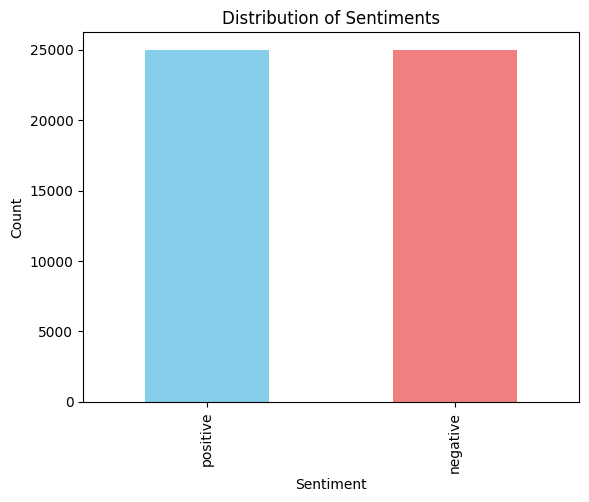

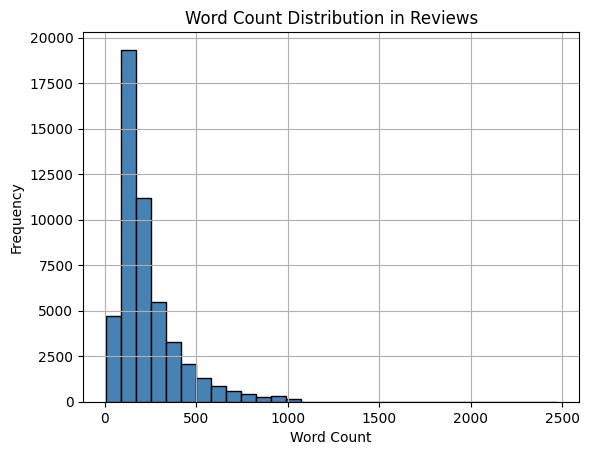

In [1]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.feature_extraction.text import CountVectorizer
# import matplotlib.pyplot as plt
# import re
# import pandas as pd
# from nltk.corpus import stopwords
# from joblib import Parallel, delayed
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, log_loss
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, LSTM, Dense
# import matplotlib.pyplot as plt
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences


import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.corpus import stopwords
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, log_loss
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import numpy as np
import tensorflow as tf
import tensorflow.keras.optimizers as optimizers



data = pd.read_csv('IMDB Dataset.csv')

# Plotting the distribution of sentiments
sentiment_counts = data['sentiment'].value_counts()
sentiment_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Word count distribution in reviews
data['word_count'] = data['review'].apply(lambda x: len(x.split()))
data['word_count'].hist(bins=30, color='steelblue', edgecolor='black')
plt.title('Word Count Distribution in Reviews')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

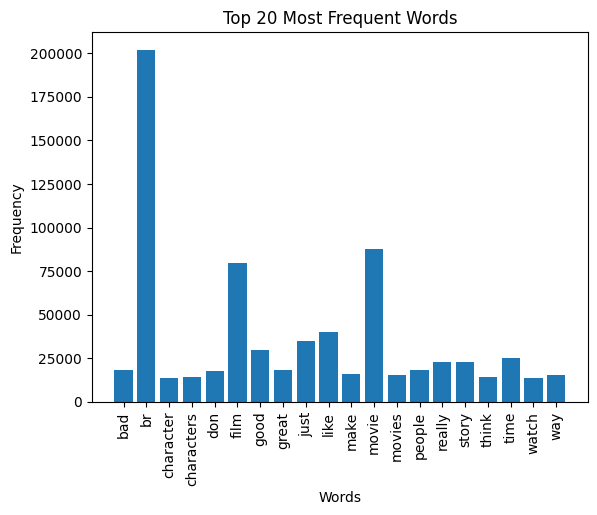

In [2]:
vectorizer = CountVectorizer(max_features=20, stop_words='english')
X = vectorizer.fit_transform(data['review'])
top_words = vectorizer.get_feature_names_out()

plt.bar(top_words, X.sum(axis=0).tolist()[0])
plt.xticks(rotation=90)
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [3]:
# Create a global variable for the list of stopwords
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

# Apply text cleaning function to reviews with parallel processing
data['review'] = Parallel(n_jobs=-1)(delayed(clean_text)(review) for review in data['review'])

# Save the cleaned data to a new CSV file
data.to_csv('Cleaned_IMDB_Dataset.csv', index=False)


In [4]:
# Tokenization and padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['review'])
sequences = tokenizer.texts_to_sequences(data['review'])
padded_sequences = pad_sequences(sequences)

# Model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=padded_sequences.shape[1]),
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilation
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1420, 64)          13726656  
                                                                 
 conv1d (Conv1D)             (None, 1416, 64)          20544     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 354, 64)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 13,780,289
Trainable params: 13,780,289
Non-trainable params: 0
____________________________________________

In [5]:
# Load the data
data = pd.read_csv('Cleaned_IMDB_Dataset.csv')

# Encode the labels
label_encoder = LabelEncoder()
data['sentiment'] = label_encoder.fit_transform(data['sentiment'])  # Assumes 'sentiment' is the label column

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['review'])
sequences = tokenizer.texts_to_sequences(data['review'])
padded_sequences = pad_sequences(sequences)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, data['sentiment'], test_size=0.2, random_state=42)

# Define the model
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=padded_sequences.shape[1]),
    LSTM(64),
    Dense(1, activation='sigmoid')
])
adam = optimizers.Adam(learning_rate=0.005)
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=2, batch_size=64, validation_split=0.2)



Epoch 1/2
500/500 [==============================] - 595s 1s/step - loss: 0.3518 - accuracy: 0.8454 - val_loss: 0.2812 - val_accuracy: 0.8850
Epoch 2/2
500/500 [==============================] - 599s 1s/step - loss: 0.1231 - accuracy: 0.9573 - val_loss: 0.3419 - val_accuracy: 0.8729


In [6]:
# Get the model's predictions on the testing data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Evaluate the model using sklearn's metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
conf_matrix = confusion_matrix(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred)

# Print the metrics
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')
print(f'ROC AUC: {roc_auc:.2f}')
print(f'Log Loss: {logloss:.2f}')
print('Confusion Matrix:')
print(conf_matrix)

313/313 [==============================] - 49s 155ms/step
Accuracy: 88.45%
Precision: 90.01%
Recall: 86.70%
F1 Score: 88.33%
ROC AUC: 0.95
Log Loss: 0.32
Confusion Matrix:
[[4476  485]
 [ 670 4369]]


In [7]:
# Continue training for additional 2  epochs
model.fit(X_train, y_train, epochs=2, batch_size=64, validation_split=0.2)


Epoch 1/2
500/500 [==============================] - 682s 1s/step - loss: 0.0492 - accuracy: 0.9844 - val_loss: 0.4281 - val_accuracy: 0.8674
Epoch 2/2
500/500 [==============================] - 600s 1s/step - loss: 0.0397 - accuracy: 0.9872 - val_loss: 0.5525 - val_accuracy: 0.8605


In [8]:
# Get the model's predictions on the testing data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Evaluate the model using sklearn's metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
conf_matrix = confusion_matrix(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred)

# Print the metrics
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')
print(f'ROC AUC: {roc_auc:.2f}')
print(f'Log Loss: {logloss:.2f}')
print('Confusion Matrix:')
print(conf_matrix)

313/313 [==============================] - 29s 93ms/step
Accuracy: 86.95%
Precision: 85.75%
Recall: 88.87%
F1 Score: 87.28%
ROC AUC: 0.94
Log Loss: 0.53
Confusion Matrix:
[[4217  744]
 [ 561 4478]]
